## This notebook is for demonstration of building stateful LSTM in Keras
#### This Notebook have successfully tested on IBM DataScience Experience 

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

/home/umcr7/ml/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_data_1 = pd.read_csv('crude_oil.csv')
df_data_1

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
5,1987-05-27,18.60
6,1987-05-28,18.60
7,1987-05-29,18.58
8,1987-06-01,18.65
9,1987-06-02,18.68


#### Data Source
U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [3]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)

(7783, 2)


In [ ]:
df_data_1_plot = df_data_1['DCOILBRENTEU'].map(lambda x : round(float(x)))
df_data_1_plot

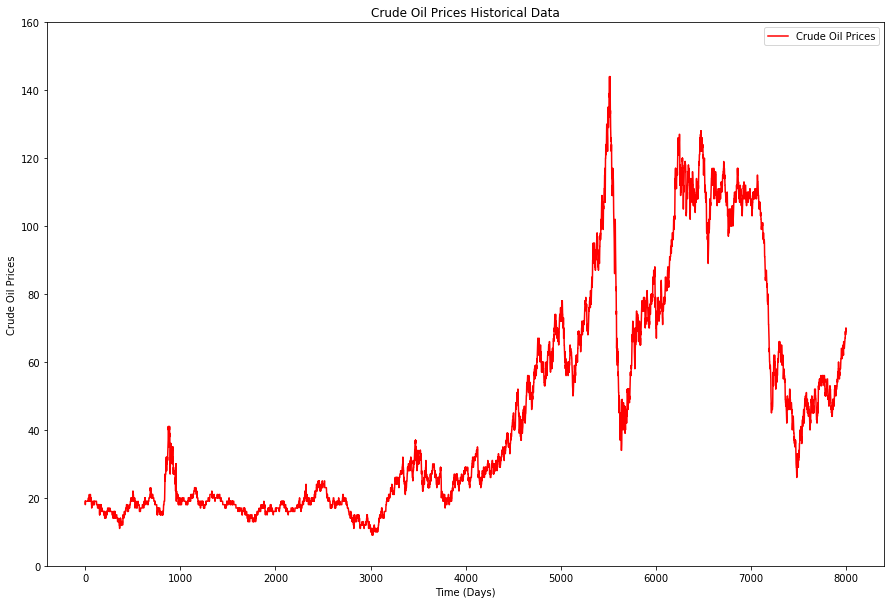

In [8]:
# # Visualising the Data
plt.figure(figsize=(15,10))
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.ylim([0, 160])
plt.legend()
plt.show()

In [26]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 20
timesteps = 30

### Batch-size and trainings-set size
With stateful LSTMs the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [10]:
length = len(df_data_1)
print (length)
length *= 1 - 0.1
print (length)

7783
7004.7


In [11]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [14]:
length = get_train_length(df_data_1, batch_size, 0.1)
print(length)

6912
6976
6976


In [15]:
#Adding timesteps * 2
upper_train = length + timesteps*2
print(upper_train)
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

7036


(7036, 1)

In [17]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(7036, 1)

In [18]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len (y_train))
print(np.array(X_train).shape)
print(np.array(y_train).shape)

7006
6976
6976
(6976, 30)
(6976, 30)


In [19]:
#keras lstm take input inform of (batch_size, timestamp, input_dim)
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(6976, 30, 1)
(6976, 30, 1)


In [20]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py #this import is for saving model

In [21]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [22]:
#This is a workaround to limit resource consumption in IBM watson free tier
from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

#### how paramter is computed for LSTM
<br>
paramters = 4 x LSTM output size x (weight_input_size + weights LSTM outputs size + 1 ) i.e. 1 for bias


In [24]:
# 1st LSTM Layer
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [27]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0326     
Epoch: 1
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0362     
Epoch: 2
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0347     
Epoch: 3
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0359     
Epoch: 4
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0346     
Epoch: 5
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0354     
Epoch: 6
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0342     
Epoch: 7
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0350     
Epoch: 8
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0340     
Epoch: 9
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0349     
Epoch: 10
Epoch 1/1
6976/6976 [==============================] - 4s - loss: 0.0337     
Epoch: 11
Epoch 1/1
6976/6976 [===========

In [29]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print (x)
    return (max(test_length_values))

In [30]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

7612
7676
7676
640


In [31]:
print(upper_train, upper_test, len(df_data_1))

7036 7736 7783


In [32]:
# construct test set
#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)

#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [33]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)

#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(640, 30, 1)
(640, 30)
(610, 1)


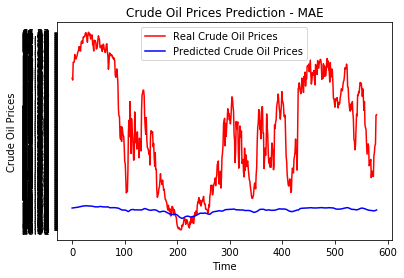

In [34]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [35]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

3.1279509006080395


In [36]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

2.641913472011172


In [38]:
import h5py
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

In [45]:
!ls 

a_m3v3hz_umcr7.log   my_model_with_mae_30_ts.h5  scratch_space
crude_oil_price.csv  __pycache__		 watsoniotp.broken.pickle
cwr_faulty	     result_healthy_pandas.csv	 watsoniotp.healthy.pickle
cwr_healthy	     rklib.py
